In [1]:
from torch.autograd import Variable
from network.Transformer import Transformer
import torchvision.transforms as transforms
import torchvision.utils as vutils
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from IPython.display import clear_output
import tensorflow as tf
import os

In [2]:
torch.__version__

'1.0.1.post2'

In [3]:
tf.__version__

'1.12.0'

## Export Pytorch pretrained Model Weights
use Tensorflow to load these weights later.

In [4]:
styles = ['Shinkai', 'Hayao', 'Paprika', 'Hosoda']
PYTORCH_STATE_DICT_DIR = "pretrained_model"
NUMPY_WEIGHTS_DIR = "pretrained_weights"

In [ ]:
for style in styles:
    pytorch_model = Transformer()
    pytorch_model.load_state_dict(
        torch.load(f'{PYTORCH_STATE_DICT_DIR}/{style}_net_G_float.pth'))
    pytorch_model.eval()    
        
    style = style.lower()
    
    save_path = f"{NUMPY_WEIGHTS_DIR}/{style}"
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    for k, v in pytorch_model.state_dict().items():
#         print(k, v.shape)
        np.save(f"{NUMPY_WEIGHTS_DIR}/{style}/{k}.npy", v.numpy())

## Pseduo code for compare TF / Pytorch output:
```python
nx = np.random.randn(2, 32, 32, 3).astype(np.float32)
tchx = torch.from_numpy(nx.transpose(0, 3, 1, 2))

tfout = sess.run(..., {placeholder: nx})
tchout = tch_net(tchx).numpy().transpose(0, 2, 3, 1)
compare(tfout, tchout)
```

### Instance Normalization check

In [5]:
# Pytorch
class NewIN(nn.Module):
    def __init__(self, dim, eps=1e-9, name):
        super(NewIN, self).__init__()
        self.scale = nn.Parameter(torch.FloatTensor(1, dim, 1, 1))
        self.shift = nn.Parameter(torch.FloatTensor(1, dim, 1, 1))
        
        self.eps = eps
        self._reset_parameters()

    def _reset_parameters(self):
        
        loaded_scale = np.load(f"weights/{name}.scale.npy")
        loaded_shift = np.load(f"weights/{name}.shift.npy")
        
        loaded_scale = np.expand_dims(loaded_scale, 0)
        loaded_scale = np.expand_dims(loaded_scale, -1)
        loaded_scale = np.expand_dims(loaded_scale, -1)
        
        loaded_shift = np.expand_dims(loaded_shift, 0)
        loaded_shift = np.expand_dims(loaded_shift, -1)
        loaded_shift = np.expand_dims(loaded_shift, -1)

        self.scale.copy_(torch.from_numpy(loaded_scale))
        self.shift.copy_(torch.from_numpy(loaded_shift))

    def forward(self, x):
        b, c = x.shape[:2]
        if torch.__version__[0] == '0':
            mean = torch.mean(x.view(b, c, -1), -1).view(b, c, 1, 1)
        else:
            mean = torch.mean(x, (2, 3), keepdim=True)
        var = torch.var(x.view(b, c, -1), -1, unbiased=False).view(b, c, 1, 1)
        out = (x - mean) / torch.sqrt(var + self.eps)
        out = out * self.scale + self.shift
        return out

# TensorFlow
def instance_norm(x, chs, mcnt, eps=1e-9, init_g=None, init_b=None):
    with tf.variable_scope(f"in_{mcnt}"):
        gamma = tf.get_variable(
            "gamma", dtype=tf.float32,
            initializer=init_g if init_g is not None else tf.ones([chs]))
        beta = tf.get_variable(
            "beta", dtype=tf.float32,
            initializer=init_b if init_b is not None else tf.zeros([chs]))
        mean, variance = tf.nn.moments(x, [1, 2], name="moments", keep_dims=True)
        x = tf.nn.batch_normalization(
            x, mean, variance, beta, gamma, eps, name='instancenorm')

        return x
    
# random choose a instance_norm' weights
loaded_scale = np.load("weights/in13_1.scale.npy")
loaded_shift = np.load("weights/in13_1.shift.npy")
print(f"loaded_scale.shape: {loaded_scale.shape}")
print(f"loaded_shift.shape: {loaded_shift.shape}")
      

chs = 64
eps = 1e-9
nx = np.random.randn(2, 64, 64, chs).astype(np.float32)
tchx = torch.from_numpy(nx.transpose(0, 3, 1, 2))

with torch.no_grad():
    tchout = NewIN(chs)(tchx)

tf.reset_default_graph()
x = tf.placeholder(tf.float32, (2, 64, 64, chs), name="input")
out_op = instance_norm(x, chs, 1, init_g=loaded_scale, init_b=loaded_shift)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfout = sess.run(out_op, {x: nx})

diff = np.sqrt(np.mean((tfout - tchout.numpy().transpose(0, 2, 3, 1))**2))
print(f"diff: {diff}")

SyntaxError: non-default argument follows default argument (<ipython-input-5-2d42e4339ed6>, line 3)

### Conv check

In [83]:
loaded_weight = np.load("weights/conv01_1.weight.npy")
loaded_bias = np.load("weights/conv01_1.bias.npy")
print(f"loaded_weight.shape: {loaded_weight.shape}") # out_channels, in_channels, kernel_size[0], kernel_size[1]
print(f"loaded_bias.shape: {loaded_bias.shape}") # the learnable bias of the module of shape (out_channels)

prev_chs = 3
chs = 64
ksize = 7
torch_conv = nn.Conv2d(prev_chs, chs, ksize)
torch_conv.weight.data = torch.from_numpy(loaded_weight)
torch_conv.bias.data = torch.from_numpy(loaded_bias)

def conv(
        x, in_chs, out_chs, k_size, stride, pad, mcnt, bias,
        init_w=None, init_b=None):  # load from numpy
    with tf.variable_scope("conv_%02d" % mcnt):
        weight = tf.get_variable(
            "kernel",
            None if init_w is not None else [k_size, k_size, in_chs, out_chs],
            tf.float32,
            init_w if init_w is not None else tf.contrib.layers.xavier_initializer())
        # "SAME" pad in tf.nn.conv2d does not do the same as pytorch
        # would do when k_size=3, stride=2, pad=1
        if pad > 0:
            x = tf.pad(x, [[0, 0], [pad, pad], [pad, pad], [0, 0]])
        x = tf.nn.conv2d(x, weight, [1, stride, stride, 1], "VALID")
        if bias:
            b = tf.get_variable(
                "bias", None, tf.float32,
                init_b if init_b is not None else tf.zeros([out_chs]))
            x = tf.nn.bias_add(x, b)
        return x

nx = np.random.randn(2, 64, 64, prev_chs).astype(np.float32)
tchx = torch.from_numpy(nx.transpose(0, 3, 1, 2))

with torch.no_grad():
    tchout = torch_conv(tchx)

tf.reset_default_graph()
x = tf.placeholder(tf.float32, (2, 64, 64, prev_chs), name="input")
out_op = conv(x, prev_chs, chs, ksize, 1, 0, 0, True, 
              init_w=np.transpose(loaded_weight, [2, 3, 1, 0]),
              init_b=loaded_bias
             )

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfout = sess.run(out_op, {x: nx})

diff = np.sqrt(np.mean((tfout - tchout.numpy().transpose(0, 2, 3, 1))**2))
print(f"diff: {diff}")

loaded_weight.shape: (64, 3, 7, 7)
loaded_bias.shape: (64,)
diff: 6.530557072892407e-08


### deconv check

In [ ]:
from torch.autograd import Variable
from network.Transformer import Transformer
import torchvision.transforms as transforms
import torchvision.utils as vutils
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from IPython.display import clear_output
import tensorflow as tf

In [48]:
loaded_weight = np.load("weights/deconv02_1.weight.npy")
loaded_bias = np.load("weights/deconv02_1.bias.npy")
print(f"loaded_weight.shape: {loaded_weight.shape}") # in_channels, out_channels, kernel_size[0], kernel_size[1]
print(f"loaded_bias.shape: {loaded_bias.shape}") # the learnable bias of the module of shape (out_channels)

prev_chs = 128
chs = 64
ksize = 3
stride = 2
padding = 1
output_padding = 1

nx = np.random.randn(2, 64, 64, prev_chs).astype(np.float32)
print(f"nx.shape: {nx.shape}")


with torch.no_grad():
    torch_deconv = nn.ConvTranspose2d(prev_chs, chs, ksize, stride, padding, output_padding)

    torch_deconv.weight.data = torch.from_numpy(loaded_weight)  # (in_channels, out_channels, kernel_size[0], kernel_size[1])
    torch_deconv.bias.data = torch.from_numpy(loaded_bias)

#     torch_deconv.weight.fill_(1)
#     torch_deconv.bias.zero_()

    tchx = torch.from_numpy(nx.transpose(0, 3, 1, 2))
    tchout = torch_deconv(tchx)
    print(f"tchout.shape: {tchout.shape}")

def deconv(
        x, in_chs, chs, k_size, stride, pad, mcnt, bias,
        init_w=None, init_b=None):
    with tf.variable_scope("deconv_%02d" % mcnt):
        weight = tf.get_variable(
            "kernel",
            None if init_w is not None else [k_size, k_size, chs, prev_chs],
            tf.float32,
            init_w if init_w is not None else tf.ones_initializer())

        
        
        input_shape = tf.shape(x)
        output_shape = (input_shape[0], input_shape[1] * 2 + 1, input_shape[2] * 2 + 1, chs)
                                                                                 
        x = tf.nn.conv2d_transpose(
            x, weight, output_shape, [1, stride, stride, 1], padding="VALID")[:, 1:, 1:]
        print(x.shape)
        
#         if pad:
#             x = tf.pad(x, [[0, 0], [pad, pad], [pad, pad], [0, 0]])
        
        if bias:
            b = tf.get_variable(
                "bias", None, tf.float32,
                init_b if init_b is not None else tf.zeros([chs]))
            x = tf.nn.bias_add(x, b)
        return x


tf.reset_default_graph()
x = tf.placeholder(tf.float32, (2, 64, 64, prev_chs), name="input")
out_op = deconv(x, prev_chs, chs, ksize, stride, padding, 1, True,
              init_w=np.transpose(loaded_weight, [2, 3, 1, 0]),
              init_b=loaded_bias
             )

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfout = sess.run(out_op, {x: nx})
    print(f"tfout.shape: {tfout.shape}")

diff = np.sqrt(np.mean((tfout - tchout.numpy().transpose(0, 2, 3, 1))**2))
print(f"diff: {diff}")

loaded_weight.shape: (128, 64, 3, 3)
loaded_bias.shape: (64,)
nx.shape: (2, 64, 64, 128)
tchout.shape: torch.Size([2, 64, 128, 128])
(2, 128, 128, 64)
tfout.shape: (2, 128, 128, 64)
diff: 8.73721930361171e-08


### ConstantPad2d

In [23]:
nx = np.random.randn(2, 64, 64, 3).astype(np.float32)

with torch.no_grad():
    tchx = torch.from_numpy(nx.transpose(0, 3, 1, 2))
    tch_pad = nn.ConstantPad2d(3, 0)
    tchout = tch_pad(tchx)
    print(f"tchout.shape: {tchout.shape}")

tchout.shape: torch.Size([2, 3, 70, 70])


In [26]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, (2, 64, 64, 3), name="input")
pad = 3
out_op = tf.pad(x, [[0, 0], [pad, pad], [pad, pad], [0, 0]], "CONSTANT")

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tfout = sess.run(out_op, {x: nx})
    print(f"tfout.shape: {tfout.shape}")

tfout.shape: (2, 70, 70, 3)


In [27]:
diff = np.sqrt(np.mean((tfout - tchout.numpy().transpose(0, 2, 3, 1))**2))
print(f"diff: {diff}")

diff: 0.0


## Build TensorFlow Model

### Reconstructed TF Graph

In [5]:
!which python

/Users/meng.lee/anaconda3/envs/cartoongan/bin/python


In [6]:
tf.__version__

'1.12.0'

In [5]:
def build_tf_graph(style, verbose=False):
    
    # modules which load pretrained pytorch weights when initialized directly
    def instance_norm(x, chs, name, eps=1e-9):
        with tf.variable_scope(name):
            gamma = tf.get_variable(
                "gamma", dtype=tf.float32,
                initializer=np.load(f"{NUMPY_WEIGHTS_DIR}/{style}/{name}.scale.npy"))
            beta = tf.get_variable(
                "beta", dtype=tf.float32,
                initializer=np.load(f"{NUMPY_WEIGHTS_DIR}/{style}/{name}.shift.npy"))
            mean, variance = tf.nn.moments(x, [1, 2], name="moments", keep_dims=True)
            x = tf.nn.batch_normalization(
                x, mean, variance, beta, gamma, eps, name='instancenorm')
            return x

    def conv(x, in_chs, out_chs, k_size, stride=1, pad=0, bias=True, name=""):
        with tf.variable_scope(name):
            weight = tf.get_variable("kernel", None, tf.float32,
                np.transpose(np.load(f"{NUMPY_WEIGHTS_DIR}/{style}/{name}.weight.npy"), [2, 3, 1, 0]))
            if pad > 0:
                x = tf.pad(x, [[0, 0], [pad, pad], [pad, pad], [0, 0]])
            x = tf.nn.conv2d(x, weight, [1, stride, stride, 1], "VALID")
            if bias:
                b = tf.get_variable(
                    "bias", None, tf.float32,
                    np.load(f"{NUMPY_WEIGHTS_DIR}/{style}/{name}.bias.npy"))
                x = tf.nn.bias_add(x, b)
            return x

    def deconv(x, in_chs, chs, k_size, stride, pad, bias=True, name=""):
        with tf.variable_scope(name):
            weight = tf.get_variable("kernel", None, tf.float32,
                np.transpose(np.load(f"{NUMPY_WEIGHTS_DIR}/{style}/{name}.weight.npy"), [2, 3, 1, 0]))
            input_shape = tf.shape(x)
            output_shape = (input_shape[0], input_shape[1] * 2 + 1, input_shape[2] * 2 + 1, chs)                                       
            x = tf.nn.conv2d_transpose(
                x, weight, output_shape, [1, stride, stride, 1], padding="VALID")[:, 1:, 1:]
            if bias:
                b = tf.get_variable(
                    "bias", None, tf.float32,
                    np.load(f"{NUMPY_WEIGHTS_DIR}/{style}/{name}.bias.npy"))
                x = tf.nn.bias_add(x, b)
            return x
    
    # build new graph for current style
    tf.reset_default_graph()
    scope = f"generator_{style}"
    with tf.variable_scope(scope):
        input_shape = [None, None, None, 3]
        input_x = tf.placeholder(tf.float32, input_shape, name="input")
        
        
        # y = F.relu(self.in01_1(self.conv01_1(self.refpad01_1(x))))
        y = tf.pad(input_x, [[0, 0], [3, 3], [3, 3], [0, 0]], "CONSTANT")
#         y = tf.pad(input_x, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT")
        y = conv(y, 3, 64, 7, 1, 0, True, "conv01_1")
        y = instance_norm(y, 64, "in01_1")
        y = tf.nn.relu(y)

        # y = F.relu(self.in02_1(self.conv02_2(self.conv02_1(y))))
        y = conv(y, 64, 128, 3, 2, 1, True, "conv02_1")
        y = conv(y, 128, 128, 3, 1, 1, True, "conv02_2")
        y = instance_norm(y, 128, "in02_1")
        y = tf.nn.relu(y)

        # t04 = F.relu(self.in03_1(self.conv03_2(self.conv03_1(y))))
        y = conv(y, 128, 256, 3, 2, 1, True, "conv03_1")
        y = conv(y, 256, 256, 3, 1, 1, True, "conv03_2")
        y = instance_norm(y, 256, "in03_1")
        t_prev = tf.nn.relu(y) # t04

        # res blocks
        # y = ...
        # tx = ...
        for i in range(4, 12):
            y = tf.pad(t_prev, [[0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT")
#             y = tf.pad(t_prev, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
            y = conv(y, 256, 256, 3, name="conv%02d_1" % i)
            y = instance_norm(y, 256, name="in%02d_1" % i)
            y = tf.nn.relu(y)

            t = tf.pad(y, [[0, 0], [1, 1], [1, 1], [0, 0]], "CONSTANT")
#             t = tf.pad(y, [[0, 0], [1, 1], [1, 1], [0, 0]], "REFLECT")
            t = conv(t, 256, 256, 3, name="conv%02d_2" % i)
            t = instance_norm(t, 256, name="in%02d_2" % i)
            t_prev = t + t_prev

            if i == 11:
                y = t_prev
                
            if verbose:
                print(f"Constructed t%02d..." % (i + 1))

        # y = F.relu(self.in12_1(self.deconv01_2(self.deconv01_1(y))))
        y = deconv(y, 256, 128, 3, 2, 1, name="deconv01_1")
        y = conv(y, 128, 128, 3, 1, 1, name="deconv01_2")
        y = instance_norm(y, 128, "in12_1")
        y = tf.nn.relu(y)

        # y = F.relu(self.in13_1(self.deconv02_2(self.deconv02_1(y))))
        y = deconv(y, 128, 64, 3, 2, 1, name="deconv02_1")
        y = conv(y, 64, 64, 3, 1, 1, name="deconv02_2")
        y = instance_norm(y, 64, "in13_1")
        y = tf.nn.relu(y)

        # y = F.tanh(self.deconv03_1(self.refpad12_1(y)))
        y = tf.pad(y, [[0, 0], [3, 3], [3, 3], [0, 0]], "CONSTANT")
#         y = tf.pad(y, [[0, 0], [3, 3], [3, 3], [0, 0]], "REFLECT")
        y = conv(y, 64, 3, 7, name="deconv03_1")
        y = tf.nn.tanh(y)

        saver = tf.train.Saver()

    to_save_vars = tf.get_collection(
        tf.GraphKeys.GLOBAL_VARIABLES, scope=scope)

    saver = tf.train.Saver(to_save_vars)
    
    return input_x, y, saver

In [6]:
style = 'shinkai'
input_x, y, saver = build_tf_graph(style)

In [7]:
input_x.op.name, y.op.name

('generator_shinkai/input', 'generator_shinkai/Tanh')

## Test forwarding input

In [8]:
%%time
nx = np.random.rand(1, 225, 225, 3).astype(np.float32)
torch_nx = torch.from_numpy(nx.transpose(0, 3, 1, 2))
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tf_out = sess.run(y, {input_x: nx})

CPU times: user 5.79 s, sys: 1.22 s, total: 7.01 s
Wall time: 2.9 s


In [9]:
tf_out.shape

NameError: name 'tf_out' is not defined

## Transform new image

In [33]:
from PIL import Image
image_path = 'clay-banks-170882-unsplash.jpg'
input_image = Image.open(image_path).convert("RGB")

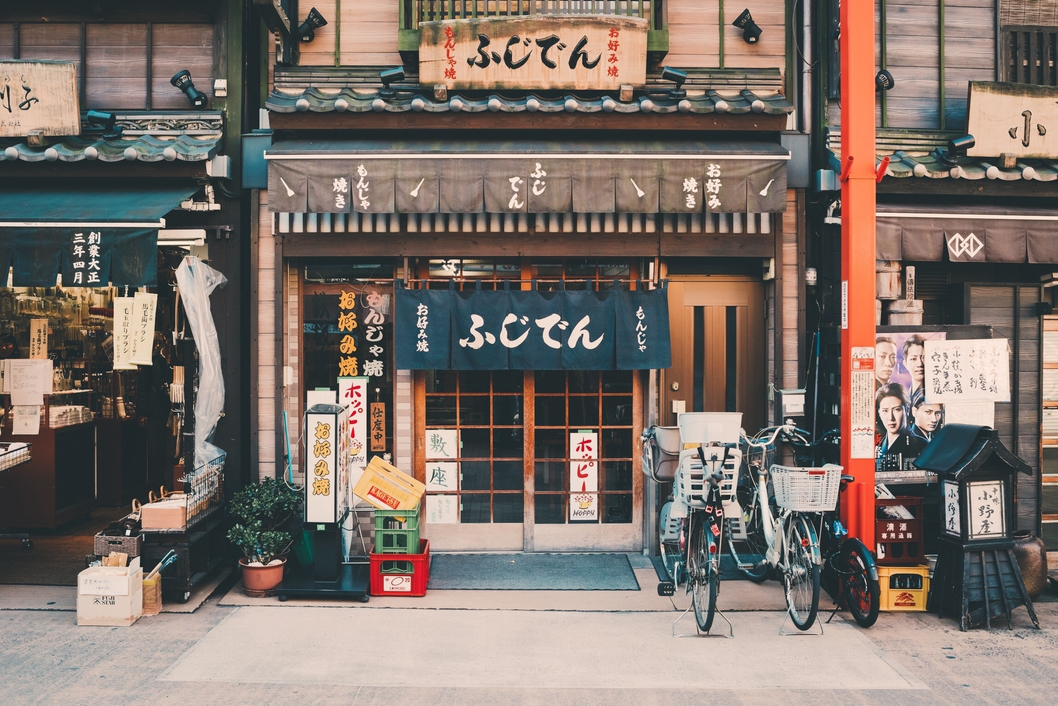

In [34]:
input_image

In [35]:
input_image = np.asarray(input_image)
print(f"original shape of image: {input_image.shape}")
input_image = input_image[:, :, [2, 1, 0]]

print(np.amin(input_image), np.amax(input_image))
input_image = np.expand_dims(input_image, axis=0)
print(f"after adding batch dim: {input_image.shape}")

original shape of image: (706, 1058, 3)
0 255
after adding batch dim: (1, 706, 1058, 3)


In [36]:
%%time
transformed_image = None
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    transformed_image = sess.run(y, {input_x: input_image})
    print(f"transformed_image.shape: {transformed_image.shape}")
    
    # post-processing
    transformed_image = transformed_image[0]
    transformed_image = transformed_image[:, :, [2, 1, 0]]
    transformed_image = transformed_image * 0.5 + 0.5
    transformed_image = transformed_image * 255
    transformed_image_path = f'transformed_{style}.jpg'
    img = Image.fromarray(transformed_image.astype('uint8'))
    img.save(transformed_image_path)
    

transformed_image.shape: (1, 708, 1060, 3)
CPU times: user 1min 10s, sys: 7.36 s, total: 1min 18s
Wall time: 14.8 s


In [43]:
# !mv finan-akbar-429027-unsplash-transformed.jpg /Users/meng.lee/git/blog/pelican-jupyter-notebook/themes/Hola10/static/images/background/

In [42]:
# !ls /Users/meng.lee/git/blog/pelican-jupyter-notebook/themes/Hola10/

favicon.ico index.html  readme.txt  static      styles.html templates


## Helper to do the all transformation process

In [40]:
%%time
def transform_image(image_path):
    from PIL import Image
    input_image = Image.open(image_path).convert("RGB")
    
    input_image = np.asarray(input_image)
    input_image = input_image[:, :, [2, 1, 0]]
    input_image = np.expand_dims(input_image, axis=0)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        transformed_image = sess.run(y, {input_x: input_image})
        print(f"transformed_image.shape: {transformed_image.shape}")

        # post-processing
        transformed_image = transformed_image[0]
        transformed_image = transformed_image[:, :, [2, 1, 0]]
        transformed_image = transformed_image * 0.5 + 0.5
        transformed_image = transformed_image * 255
        transformed_image_path = image_path.split("/")[-1].replace(".jpg", "-transformed.jpg")
        img = Image.fromarray(transformed_image.astype('uint8'))
        img.save(transformed_image_path)

image_paths = [
    "galen-crout-87390-unsplash.jpg",
    "jezael-melgoza-1167932-unsplash.jpg",
    "michel-catalisano-477475-unsplash.jpg",
    "nick-wood-497114-unsplash.jpg",
    "finan-akbar-429027-unsplash.jpg",
    "andre-benz-250740-unsplash.jpg",
    "clay-banks-170882-unsplash.jpg"
]
for image_path in image_paths:
    transform_image(image_path)

transformed_image.shape: (1, 768, 1148, 3)
transformed_image.shape: (1, 816, 1200, 3)
transformed_image.shape: (1, 748, 1244, 3)
transformed_image.shape: (1, 760, 1140, 3)
transformed_image.shape: (1, 804, 1204, 3)
transformed_image.shape: (1, 808, 1172, 3)
transformed_image.shape: (1, 708, 1060, 3)
CPU times: user 10min 6s, sys: 1min 5s, total: 11min 11s
Wall time: 1min 52s


## [Important] Whole process: Export tf graphs to tfjs json models


In [27]:
def freeze_graph(style, sess, saver, model_dir, output_node_names, get_output_node_names_realtime=False):
    """Extract the sub graph defined by the output nodes and convert
    all its variables into constant

    Args:
        model_dir: the root folder containing the checkpoint state file
        output_node_names: a string, containing all the output node's names,
                            comma separated
    """
    from tensorflow.tools.graph_transforms import TransformGraph
    
    if not tf.gfile.Exists(model_dir):
        raise AssertionError(
            "Export directory doesn't exists. Please specify an export "
            "directory: %s" % model_dir)

    if not output_node_names and not get_output_node_names_realtime:
        print("You need to supply the name of a node to --output_node_names.")
        return -1

    # We retrieve our checkpoint fullpath
    checkpoint = tf.train.get_checkpoint_state(model_dir)
    input_checkpoint = checkpoint.model_checkpoint_path

    # We precise the file fullname of our freezed graph
    absolute_model_dir = "/".join(input_checkpoint.split('/')[:-1])
    output_graph = absolute_model_dir + f"/frozen_model_{style}.pb"

    # We clear devices to allow TensorFlow to control on which device it will load operations
    clear_devices = True

    # We start a session using a temporary fresh Graph
    with tf.Session(graph=tf.Graph()) as sess:
        # We import the meta graph in the current default Graph
        saver = tf.train.import_meta_graph(input_checkpoint + '.meta', clear_devices=clear_devices)

        # We restore the weights
        saver.restore(sess, input_checkpoint)

        # We use a built-in TF helper to export variables to constants
        if type(output_node_names) is not list:
            output_node_names = [output_node_names]

        print(f'output_node_names: {output_node_names}')
        output_graph_def = tf.graph_util.convert_variables_to_constants(
            sess,  # The session is used to retrieve the weights
            tf.get_default_graph().as_graph_def(),  # The graph_def is used to retrieve the nodes
            output_node_names  # The output node names are used to select the usefull nodes
        )
        
        # optimize
        output_graph_def = TransformGraph(output_graph_def, ["input"], output_node_names,
                                               ["strip_unused_nodes",
#                                                 "fuse_convolutions",
                                                "fold_constants(ignore_errors=true)",
                                                "fold_batch_norms",
                                                "fold_old_batch_norms"])
        

        # Finally we serialize and dump the output graph to the filesystem
        with tf.gfile.GFile(output_graph, "wb") as f:
            f.write(output_graph_def.SerializeToString())
#         print("%d ops in the final graph." % len(output_graph_def.node))
        print()
        print('-' * 50)

    return output_graph_def

In [28]:
!rm -rf tfjs_pb_models/*
!rm -rf tfjs_json_models/*

In [29]:
CKPT_DIR = "ckpts"
TFJS_PB_MODEL_DIR = "tfjs_pb_models"
TFJS_JSON_MODEL_DIR = "tfjs_json_models"

for style in [s.lower() for s in styles]:
    print(f"Exporting {style} graph to tfjs model...")

    input_x, y, saver = build_tf_graph(style)    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        tf.train.write_graph(
            sess.graph.as_graph_def(), CKPT_DIR, f"generator_{style}.pbtxt", as_text=True)
        saver.save(sess, os.path.join(CKPT_DIR, f"generator_{style}"))
    
        freeze_graph(style, sess, saver, CKPT_DIR, f"generator_{style}/Tanh")
    
    # frozengraph to tfjs model
    !tensorflowjs_converter \
        --quantization_bytes=1 \
        --input_format=tf_frozen_model \
        --output_node_names='generator_{style}/Tanh' \
        {CKPT_DIR}/frozen_model_{style}.pb \
        {TFJS_PB_MODEL_DIR}/{style}
    
    # tfjs pb model to json model
    !cd ~/git/tfjs-converter \
    && yarn ts-node tools/pb2json_converter.ts \
    ~/git/personal-repos/cartoongan/{TFJS_PB_MODEL_DIR}/{style} \
    ~/git/personal-repos/cartoongan/{TFJS_JSON_MODEL_DIR}/{style}    

Exporting shinkai graph to tfjs model...
INFO:tensorflow:Restoring parameters from ckpts/generator_shinkai
output_node_names: ['generator_shinkai/Tanh']
INFO:tensorflow:Froze 94 variables.
INFO:tensorflow:Converted 94 variables to const ops.

--------------------------------------------------
Using TensorFlow backend.
2019-04-13 18:00:21.556418: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:501] Optimization results for grappler item: graph_to_optimize
2019-04-13 18:00:21.556445: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:503]   debug_stripper: Graph size after: 659 nodes (0), 756 edges (0), time = 21.106ms.
2019-04-13 18:00:21.556451: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:503]   model_pruner: Graph size after: 544 nodes (-115), 641 edges (-115), time = 43.145ms.
2019-04-13 18:00:21.556456: I tensorflow/core/grappler/optimizers/meta_optimizer.cc:503]   constant folding: Graph size after: 544 nodes (0), 641 edges (0), time = 120.841ms.
2019-04-13

In [16]:
!ls -lh tfjs_json_models/shinkai/

total 21984
-rw-r--r--  1 meng.lee  staff   4.0M Apr  3 21:32 group1-shard1of3
-rw-r--r--  1 meng.lee  staff   4.0M Apr  3 21:32 group1-shard2of3
-rw-r--r--  1 meng.lee  staff   2.6M Apr  3 21:32 group1-shard3of3
-rw-r--r--  1 meng.lee  staff   120K Apr  3 21:32 model.json


## Useful commands

Command to transform frozengraph to tfjs model

```commandline
tensorflowjs_converter \
    --input_format=tf_frozen_model \
    --output_node_names='generator/Tanh' \
    ckpts/frozen_model.pb \
    web_model
```

Command to transform tfjs pb model to json model
```commandline
!cd ~/git/tfjs-converter \
    && yarn ts-node tools/pb2json_converter.ts \
    ~/git/personal-repos/cartoongan/web_model/{style} \
    ~/git/personal-repos/cartoongan/json_model/{style}
```

## Load graph and transform

In [19]:
# from PIL import Image
# image_path = 'source/test.jpg'  # horizontal
# input_image = Image.open(image_path).convert("RGB")
# input_image = np.asarray(input_image)
# input_image = np.expand_dims(input_image, 0)

In [20]:
graph = tf.Graph()
sess = tf.Session(graph=graph)
gd = tf.GraphDef()
with tf.gfile.GFile("ckpts/frozen_model.pb", 'rb') as f:
    gd.ParseFromString(f.read())
with graph.as_default():
    tf.import_graph_def(gd, name='')
graph.finalize()

input_op = graph.get_tensor_by_name("input:0")
out_op = graph.get_tensor_by_name("generator/Tanh:0")

transformed_image = sess.run(out_op, {input_op: input_image})

In [21]:
transformed_image = transformed_image[0]
transformed_image = transformed_image[:, :, [2, 1, 0]]
transformed_image = transformed_image * 0.5 + 0.5
transformed_image = transformed_image * 255
transformed_image_path = 'transformed.jpg'

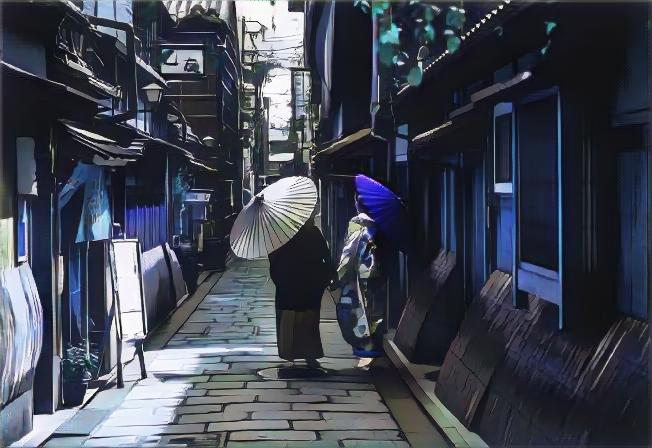

In [22]:
img = Image.fromarray(transformed_image.astype('uint8'))
img.save(transformed_image_path)
Image.open(transformed_image_path).convert("RGB")

## Pytorch Model with pretrained weights
Used for checking the correctness of reconstructed TF model

In [402]:
class PretrainedIN(nn.Module):
    def __init__(self, dim, name, eps=1e-9):
        super(PretrainedIN, self).__init__()
        self.name = name
        self.scale = nn.Parameter(torch.FloatTensor(1, dim, 1, 1))
        self.shift = nn.Parameter(torch.FloatTensor(1, dim, 1, 1))
        self.eps = eps
        self._reset_parameters()

    def _reset_parameters(self):
        loaded_scale = np.load(f"weights/{self.name}.scale.npy")
        loaded_shift = np.load(f"weights/{self.name}.shift.npy")
        
        loaded_scale = np.expand_dims(loaded_scale, 0)
        loaded_scale = np.expand_dims(loaded_scale, -1)
        loaded_scale = np.expand_dims(loaded_scale, -1)
        
        loaded_shift = np.expand_dims(loaded_shift, 0)
        loaded_shift = np.expand_dims(loaded_shift, -1)
        loaded_shift = np.expand_dims(loaded_shift, -1)

        self.scale.copy_(torch.from_numpy(loaded_scale))
        self.shift.copy_(torch.from_numpy(loaded_shift))

    def forward(self, x):
        b, c = x.shape[:2]
        if torch.__version__[0] == '0':
            mean = torch.mean(x.view(b, c, -1), -1).view(b, c, 1, 1)
        else:
            mean = torch.mean(x, (2, 3), keepdim=True)
        var = torch.var(x.view(b, c, -1), -1, unbiased=False).view(b, c, 1, 1)
        out = (x - mean) / torch.sqrt(var + self.eps)
        out = out * self.scale + self.shift
        return out

class PretrainedConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, name=""):
        super(PretrainedConv2d, self).__init__()
        self.name = name
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self._reset_parameters()

    def _reset_parameters(self):
        self.conv.weight.data = torch.from_numpy(np.load(f"weights/{self.name}.weight.npy"))
        self.conv.bias.data = torch.from_numpy(np.load(f"weights/{self.name}.bias.npy"))

    def forward(self, x):
        return self.conv(x)

class PretrainedConvTranspose2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, name=""):
        super(PretrainedConvTranspose2d, self).__init__()
        self.name = name
        self.conv_transpose = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, output_padding)
        self._reset_parameters()

    def _reset_parameters(self):
        self.conv_transpose.weight.data = torch.from_numpy(np.load(f"weights/{self.name}.weight.npy"))
        self.conv_transpose.bias.data = torch.from_numpy(np.load(f"weights/{self.name}.bias.npy"))

    def forward(self, x):
        return self.conv_transpose(x)

In [403]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PretrainedTransformer(nn.Module):
    def __init__(self):
        super(PretrainedTransformer, self).__init__()
        self.refpad01_1 = nn.ConstantPad2d(3, 0)
        self.conv01_1 = PretrainedConv2d(3, 64, 7, name="conv01_1")
        self.in01_1 = PretrainedIN(64, name="in01_1")

        self.conv02_1 = PretrainedConv2d(64, 128, 3, 2, 1, name="conv02_1")
        self.conv02_2 = PretrainedConv2d(128, 128, 3, 1, 1, name="conv02_2")
        self.in02_1 = PretrainedIN(128, name="in02_1")
        
        self.conv03_1 = PretrainedConv2d(128, 256, 3, 2, 1, name="conv03_1")
        self.conv03_2 = PretrainedConv2d(256, 256, 3, 1, 1, name="conv03_2")   
        self.in03_1 = PretrainedIN(256, name="in03_1")
        
        self.deconv01_1 = PretrainedConvTranspose2d(256, 128, 3, 2, 1, 1, name="deconv01_1")
        self.deconv01_2 = PretrainedConv2d(128, 128, 3, 1, 1, name="deconv01_2")
        self.in12_1 = PretrainedIN(128, name="in12_1")
        
        self.deconv02_1 = PretrainedConvTranspose2d(128, 64, 3, 2, 1, 1, name="deconv02_1")
        self.deconv02_2 = PretrainedConv2d(64, 64, 3, 1, 1, name="deconv02_2")
        self.in13_1 = PretrainedIN(64, name="in13_1")
        
        self.refpad12_1 = nn.ConstantPad2d(3, 0)
        self.deconv03_1 = PretrainedConv2d(64, 3, 7, name="deconv03_1")
                
    def forward(self, x):
        y = F.relu(self.in01_1(self.conv01_1(self.refpad01_1(x))))  
        y = F.relu(self.in02_1(self.conv02_2(self.conv02_1(y))))
        t_prev = F.relu(self.in03_1(self.conv03_2(self.conv03_1(y)))) # t04
        
        # res blocks
        for i in range(4, 12):
            y = nn.ConstantPad2d(1, 0)(t_prev)
            y = PretrainedConv2d(256, 256, 3, name="conv%02d_1" % i)(y)
            y = PretrainedIN(256, name="in%02d_1" % i)(y)
            y = F.relu(y)
            
            t = nn.ConstantPad2d(1, 0)(y)
            t = PretrainedConv2d(256, 256, 3, name="conv%02d_2" % i)(t)
            t = PretrainedIN(256, name="in%02d_2" % i)(t)
            t_prev = t + t_prev
            
            if i == 11:
                y = t_prev
        
        y = F.relu(self.in12_1(self.deconv01_2(self.deconv01_1(y))))
        y = F.relu(self.in13_1(self.deconv02_2(self.deconv02_1(y))))
        y = F.tanh(self.deconv03_1(self.refpad12_1(y)))
        
        return y

In [404]:
with torch.no_grad():
    torch_out = PretrainedTransformer()(torch_nx)

In [405]:
diff = np.sqrt(np.mean((tf_out - torch_out.numpy().transpose(0, 2, 3, 1))**2))
print(f"diff: {diff}")

diff: 3.182120508427033e-06
